<a href="https://colab.research.google.com/github/srijibbose/Ensemble-Model/blob/main/Ensemble_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!git clone https://github.com/sremedios/nifti_image_generator.git
!pip install -U scipy==1.2.0
!pip install SimpleITK
from nifti_image_generator.utils.nifti_image import NIfTIImageDataGenerator
from nifti_image_generator.utils.augmentations import *
from nifti_image_generator.utils.utils import parse_args, now
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential
import os
import cv2
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, concatenate, Activation, Add, ZeroPadding2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import SimpleITK as sitk
import scipy.misc
from PIL import Image
import numpy as np
import scipy.misc
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import nibabel as nib #reading MR images
#from sklearn.cross_validation import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

## Pre Processing

In [ ]:
def filterfun(image):
    inputimage=image
    filter=sitk.MedianImageFilter();
    inputImage=filter.Execute(inputimage)
    #print("Finished filter.....")
    return inputImage

def N4(inputImage,maskImage):
    #print("N4 bias correction runs.")

    
    #inputImage=image
    
    #maskImage = mask
    
    #sitk.WriteImage( maskImage, os.path.join(path2,"finalmask.nii"))
    
    maskImage = sitk.Cast(inputImage,sitk.sitkUInt8)
    inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter();
    output = corrector.Execute(inputImage,maskImage)
    #sitk.WriteImage( output, os.path.join(path2,"final_output3.nii"))
    
    #print("Finished N4 Bias Field Correction.....")
    return output
   

def norm(inputimage):
    img=sitk.GetArrayFromImage(inputimage)
    mean = np.mean(img)
    std = np.std(img)
    #print(std,mean)
    if std == 0:
      return inputimage
    else:
      inputimage= (inputimage - mean) / std
      #print("Finished norm....")
      return inputimage
def datas_gen(location,batch_size,final_size):
  c=0
  start=0
  while(True):
    image_load = np.array(images[c])
    mask_load = np.array(masks[c])
    yield image_load[start:start+batch_size,:,:,:] , mask_load[start:start+batch_size,:,:,:]
    if(start+batch_size<155):
      start=0
      c=c+1
      if(c>160):
        c=0
    else:
      start=start+batch_size

.........
...........

image_loc = "drive/My Drive/t2/"
image_loc2 = "drive/My Drive/t1/"
#_______Fiding non-zero mask index____________
    
    image_location = image_loc
    mask_location = "drive/My Drive/seg/"
    sorted_image_list = sorted(os.listdir(image_location))
    sorted_mask_list = sorted(os.listdir(mask_location))
    non_zero_index=[]
    
    for i in range(210):
        #print("i "+str(i))
        #globber_image = glob.glob(image_location + sorted_image_list[i])
        globber_mask = glob.glob(mask_location + sorted_mask_list[i])
        #images = sisitktk.ReadImage(globber_image[0])
        masks = sitk.ReadImage(globber_mask[0])
        masks = sitk.GetArrayFromImage(masks)
        #images = sitk.GetArrayFromImage(images)
        #masks=to_categorical(masks,num_classes=5)
        masks=tumor(masks,label_value)
        #if label_num == 4:
          #masks[masks != 4] = 0
          #masks[masks == 4] = 1
        #masks=masks[:,:,:,4]
        start=-1
        print("Calculating image "+str(i))
        for j in range(155):
          if(np.max(masks[j])==1):
              start=j
              break
        for j in range(155):
            if(np.max(masks[154-j])==1):
              non_zero_index.append((start,154-j))
              break
        del masks
    print("Finished.")
    print("Loading Training images...")
image=[]
mask=[]
sorted_image_list = sorted(os.listdir(image_location))
sorted_mask_list = sorted(os.listdir(mask_location))
label_num=4
for i in range(171):
  globber_image = glob.glob(image_location + sorted_image_list[i])
  globber_mask = glob.glob(mask_location + sorted_mask_list[i])
  images = sitk.ReadImage(globber_image[0])
  masks = sitk.ReadImage(globber_mask[0])
  masks = sitk.GetArrayFromImage(masks)
  images = sitk.GetArrayFromImage(images)
  masks=tumor(masks,label_value)
  #if label_num == 4:
         # masks[masks != 4] = 0
          #masks[masks == 4] = 1
  #masks=to_categorical(masks,num_classes=5)
  masks=masks[:,24:216,24:216]
  images=images[:,24:216,24:216]
  for j in range(non_zero_index[i][0],non_zero_index[i][1]+1):
    #masks=masks[non_zero_index[i][0]:non_zero_index[i][1],24:216,24:216,4].reshape(-1,192,192,1)
    #images=images[non_zero_index[i][0]:non_zero_index[i][1],24:216,24:216].reshape(-1,192,192,1)
    if(np.sum(masks[j])>=400):
      image.append(np.array(images[j]).reshape(-1,192,192))
      mask.append(np.array(masks[j]).reshape(-1,192,192))
  print("Image "+str(i)+" loaded.")
  del images
  del masks
print("Training images loaded.")
print("Converting NumPy Array")
image = np.array(image).reshape(-1,192,192,1)
mask=np.array(mask).reshape(-1,192,192,1)


...........
...........
............
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     rotation_range=90,
                     horizontal_flip=True,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2
                     )
seed=1
batch_size=32
train = ImageDataGenerator(**data_gen_args)
train_X = train.flow(train_image,batch_size=batch_size,seed=seed)
train_Y = train.flow(train_mask,batch_size=batch_size,seed=seed)
valid = ImageDataGenerator()
valid_X = valid.flow(valid_image,batch_size=batch_size,seed=seed)
valid_Y = valid.flow(valid_mask,batch_size=batch_size,seed=seed)
def train_gen(train_X,train_Y):
  traingen = zip(train_X,train_Y)
  for (i,j) in traingen:
    yield i,j
def valid_gen(valid_X,valid_Y):
  validgen = zip(valid_X,valid_Y)
  for (i,j) in validgen:
    yield i,j


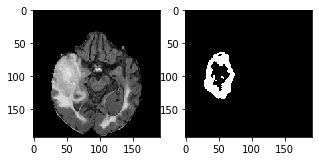

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(image[20], (192,192))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(mask[21], (192,192))
plt.imshow(curr_img, cmap='gray')

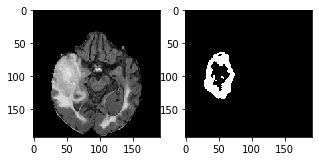

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(image[20], (192,192))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(mask[21], (192,192))
plt.imshow(curr_img, cmap='gray')

## Models

### UNET

In [ ]:
def UNET_ELU():

  inputs = Input((192,192, 1))

  c1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (inputs)
  #c1 = BatchNormalization()(c1)
  c1 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (c1)
  #c1 = BatchNormalization()(c1)
  #c1 = Dropout(0.3)(c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (p1)
  #c2 = BatchNormalization()(c2)
  c2 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (c2)
  #c2 = BatchNormalization()(c2)
  #c2 = Dropout(0.3)(c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (p2)
  #c3 = BatchNormalization()(c3)
  c3 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (c3)
  #c3 = BatchNormalization()(c3)
  #c3 = Dropout(0.3)(c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  ............................
  ................................
  ............................

  u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(512, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (u6)
  #c6 = BatchNormalization()(c6)
  c6 = Conv2D(512, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (c6)
  #6 = BatchNormalization()(c6)

  u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (u7)
  #c7 = BatchNormalization()(c7)
  c7 = Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (c7)
  #c7 = BatchNormalization()(c7)

  u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (u8)
  #c8 = BatchNormalization()(c8)
  c8 = Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (c8)
  #c8 = BatchNormalization()(c8)

  u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (u9)
  #c9 = BatchNormalization()(c9)
  c9 = Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

### Segnet

In [ ]:
class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


.............................
.......................

def Segnet(n_classes, input_height=416, input_width=608, vgg_level=4):

    img_input = Input(shape=(input_height, input_width,1))
    pool_size=(2,2)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool1')(x)
    x, mask_1 = MaxPoolingWithArgmax2D(pool_size)(x)
    f1 = x

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    x, mask_2 = MaxPoolingWithArgmax2D(pool_size)(x)
    f2 = x

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool1')(x)
    x, mask_3 = MaxPoolingWithArgmax2D(pool_size)(x)
    f3 = x

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool1')(x)
    x, mask_4 = MaxPoolingWithArgmax2D(pool_size)(x)
    f4 = x

    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool1')(x)
    x, mask_5 = MaxPoolingWithArgmax2D(pool_size)(x)
    f5 = x
    #vgg.load_weights(VGG_Weights_path)

    levels = [f1, f2, f3, f4, f5]

    o = levels[vgg_level]

    o = MaxUnpooling2D(pool_size)([o, mask_5])
    #o = ZeroPadding2D((1,1))(o)
    o = Conv2D(512,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)
    o = Conv2D(512,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)
    o = Conv2D(512,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)

    #o = UpSampling2D((2,2))(o)
    o = MaxUnpooling2D(pool_size)([o, mask_4])
    #o = ZeroPadding2D((1,1))(o)
    o = Conv2D(256,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)
    o = Conv2D(256,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)
    o = Conv2D(256,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)

    #o = UpSampling2D((2,2))(o)
    o = MaxUnpooling2D(pool_size)([o, mask_3])
    #o = ZeroPadding2D((1,1))(o)
    o = Conv2D(128,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)
    o = Conv2D(128,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)
    o = Conv2D(128,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)

    #o = UpSampling2D((2, 2))(o)
    o = MaxUnpooling2D(pool_size)([o, mask_2])
    #o = ZeroPadding2D((1, 1))(o)
    o = Conv2D(64, (3, 3),activation="relu", padding='same')(o)
    o = BatchNormalization()(o)
    o = Conv2D(64, (3, 3),activation="relu", padding='same')(o)
    o = BatchNormalization()(o)

    #o = Conv2D(64,(3,3),activation="relu",padding='same')(o)
    #o = UpSampling2D((2,2))(o)
    o = MaxUnpooling2D(pool_size)([o, mask_1])
    o = Conv2D(64,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)
    o = Conv2D(64,(3,3),activation="relu",padding='same')(o)
    o = BatchNormalization()(o)
    
    o = Conv2D(n_classes,(3,3),activation="sigmoid",padding='same')(o)
    o_shape = Model(img_input,o).output_shape
    outputHeight = o_shape[2]
    outputWidth = o_shape[3]


    #o = (Reshape((-1,outputHeight*outputWidth)))(o)
    #o = (Permute((2,1)))(o)
    #o = (Activation('softmax'))(o)
    model = Model(img_input,o)
    model.outputWidth = outputWidth
    model.outputHeight = outputHeight

    return  model

## Training

In [ ]:
model = Segnet(1,192,192)
model.compile(loss=bce_dice_loss,optimizer="adam",metrics=[IoU,'accuracy',dice_score])
from keras.callbacks import CSVLogger
label=label_value
stringval='t1ce_'
  #only enhancing
if label == 4:
  csv_logger = CSVLogger('segnet_'+stringval+'enhancingtrain.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint('segnet_'+stringval+'ENHANCING.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
    #only edema
if label == 2:
  csv_logger = CSVLogger('segnet_'+stringval+'edematraining.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint('segnet_'+stringval+'EDEMA.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
  #tumor core
if label == 1:
  csv_logger = CSVLogger('segnet_'+stringval+'coretraining.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint('segnet_'+stringval+'CORE.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
  #complete tumor
if label == 5:
  csv_logger = CSVLogger('segnet_'+stringval+'completetraining.log', separator=',', append=False)
  model_checkpoint = ModelCheckpoint('segnet_'+stringval+'COMPLETE.h5', monitor='val_dice_score',mode='max',verbose=1, save_best_only=True)
  
#csv_logger = CSVLogger('training.log', separator=',', append=False)
#model.fit(X_train, Y_train, callbacks=[csv_logger])
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return 0.8*binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
import tensorflow as tf
def calculate_iou(y_true, y_pred,smooth=1):

  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def IoU(y_true, y_pred):
        
    iou = tf.py_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou
def dice_score(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score
from sklearn.metrics import jaccard_score
def J_score(y_true, y_pred):
    jscore=jaccard_score(y_true, y_pred, average='macro')
    return jscore
    
earlystopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=5, 
    verbose=1, 
    restore_best_weights=True)

reducelr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    verbose=1,  
    min_delta=0.000001 )
start_time = time.time()
history=model.fit_generator(train_generator,steps_per_epoch=(train_shape/batch_size),epochs=100,validation_data=valid_generator,validation_steps=(valid_shape/batch_size),callbacks=[model_checkpoint,reducelr,csv_logger])
end_time = time.time()
t=end_time-start_time
print('execution time is:')
print(t)

## Result

In [ ]:
model.load_weights("drive/My Drive/weight_Unet/flair_core1.h5")
prediction_masks = model1.predict(test_image)
prediction_masks[prediction_masks>0.5]=1
prediction_masks[prediction_masks<0.5]=0
mse=mean_squared_error(test_mask.reshape(-1),prediction_masks_test.reshape(-1))
print(mse)
#Plotting ROC curve
y_pred = model1.predict(test_image).ravel()
y_pred [y_pred >0.5]=1
y_pred [y_pred <0.5]=0
#y_prob=.model.predict_proba(test_image)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_mask.reshape(-1), y_pred.reshape(-1))
#fpr , tpr , thresholds = roc_curve ( test_mask , y_val_cat_prob)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Flair_Core (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print(classification_report(prediction_masks_test.reshape(-1),test_mask.reshape(-1)))
score = f1_score(test_mask.reshape(-1), prediction_masks_test.reshape(-1),average='macro')
# print
print(score)
jaccard_score(test_mask.reshape(-1), prediction_masks_test.reshape(-1),pos_label=1, average='binary')
